# 2024 CITS4012 Project

# ReadMme

# 1. Dataset Processing

## Importing Libraries

In [1]:
import re
import json
import nltk
import time
import math
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt

## Loading Datasets

In [2]:
# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist() + val_data['sentence'].tolist()
training_a = train_data['aspect'].tolist() + val_data['aspect'].tolist()
training_y = train_data['polarity'].tolist() + val_data['polarity'].tolist()
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [3]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Sentiment Distribution
sentiment_distribution = train_data['polarity'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7978
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Sentiment Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)         

## Data Preprocessing

In [4]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 656.4 kB/s eta 0:00:20
      --------------------------------------- 0.3/12.8 MB 2.2 MB/s eta 0:00:06
     - -------------------------------------- 0.5/12.8 MB 3.1 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 3.7 MB/s eta 0:00:04
     --- ------------------------------------ 1.0/12.8 MB 3.7 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 4.2 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/12.8 MB 4.3 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 4.5 MB/s eta 0:00:03
     ------ --------------------------------- 2.1/12.8 MB 4.6 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 4.8 MB/s eta 0:00:03
     -------- ------------------------------- 2.6/12.8 MB 4.8 MB/

In [5]:
# Punctuation Removal
def remove_punctuation_re(x):
    x = re.sub(r'[^\w\s]', '', x)
    return x

nltk.download('punkt')

# Stopwords Removal
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(x):
    doc = nlp(x)
    x = [word.text for word in doc if not word.is_stop]
    return x

# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem(x):
    x = [stemmer.stem(word) for word in x]
    return x

# Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    x = [lemmatizer.lemmatize(word) for word in x]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = remove_punctuation_re(sentence)      # Remove punctuation
        tokens = remove_stopwords(sentence)             # Remove stopwords / Tokenise
        # tokens = stem(tokens)                           # Stemming
        # tokens = lemmatize(tokens)                      # Lemmatisation
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)

## Create Word Vocabulary

In [7]:
# Get longest sentence length
longest_sentence = max(train_x_token, key=len)
MAX_LENGTH = len(longest_sentence)

# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<PAD>': 0, '<SEP>': 1}
review = train_x_token + test_x_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
word_list = list(word_to_idx.keys())
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}

## Convert Words to Index form

In [52]:
def list_to_index(token_list, word_to_idx):
    idx_list = []
    for tokens in token_list:
        idx_list.append([word_to_idx[token] for token in tokens])
    return idx_list

def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Append aspect to the end of the sentence
def combine_sentence_aspect(sentence, aspect, has_sep):
    if has_sep:
        sep_idx = word_to_idx['<SEP>']
        combined_idx = sentence + [sep_idx] + [aspect]
    else:
        combined_idx = sentence + [aspect]
    return combined_idx

# Append aspect after every word
def combine_repeat_aspect(sentence, aspect, has_sep):
    output = []
    for word in sentence:
        if has_sep:
            sep_idx = word_to_idx['<SEP>']
            output = output + [word] + [sep_idx] + [aspect]
        else:
            output = output + [word] + [aspect]
    return output

# Token index lists for training data
train_x_idx = list_to_index(train_x_token, word_to_idx)
train_a_idx = string_to_index(training_a, word_to_idx)
train_y_idx = string_to_index(training_y, polarity_to_idx)

# Max length of the sentence after appending aspect
MAX_COMBINED_LENGTH = MAX_LENGTH + 1
MAX_REP_LENGTH = MAX_LENGTH*2
MAX_REPSEP_LENGTH = MAX_LENGTH*3

## Pretrained Word Embeddings from Glove

In [ ]:
glove_model = api.load("glove-twitter-50")
glove_weights = torch.FloatTensor(glove_model.vectors)

# 2. Model Implementation

## Model Variants

In [74]:
NO_ASPECT = 'no aspect'
ASPECT_EMBED = 'aspect embedding'
WITH_SEP = 'with separator'
NO_SEP = 'no separator'
ASPECT_REP_SEP = 'aspect repeat with separator'
ASPECT_REP = 'aspect repeat'

## Model Architecture

In [77]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, hidden_size, embedding, integration, num_layers=1):
        super(Encoder, self).__init__()
        self.integration_type = integration
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        
    def forward(self, input, hidden, cell, aspect):
        word_embedding = self.embedding(input).view(1, 1, -1)
        if self.integration_type in [WITH_SEP, NO_SEP, ASPECT_REP_SEP, ASPECT_REP, NO_ASPECT]:
            output, (hidden, cell) = self.lstm(word_embedding, (hidden, cell))
        elif self.integration_type == ASPECT_EMBED:
            aspect_embedding = self.embedding(aspect).view(1, 1, -1)
            embedded = torch.cat((aspect_embedding, word_embedding), 0)
            output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
            
        return output, (hidden, cell)
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention='dot_product'):
        super(Decoder, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.linear = nn.Linear(self.hidden_size*2, self.output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        if self.attention_type == 'dot_product':            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        elif self.attention_type == 'scaled_dot_product':   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        elif self.attention_type == 'cosine_similarity':
            query = hidden / torch.norm(hidden, dim=-1)
            keys = encoder_hiddens / torch.norm(encoder_hiddens.T, dim=-1)
            norm_product = torch.bmm(query, keys.T.unsqueeze(0))
            attn_weights = F.softmax(norm_product, dim=-1)

        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output
    
    def forward(self, hidden, encoder_hiddens):
        concat_output = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.linear(concat_output), dim=1)
        return output

In [78]:
# Function to get time elapse for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Function to feep input tensor into encoder
def feed_encoder(encoder, input_tensor, aspect_tensor, max_length):
    encoder_hiddens = torch.zeros(max_length, encoder.hidden_size) # For attention mechanism
    encoder_hidden = encoder.init_hidden() # Hidden state for encoder
    encoder_cell = encoder.init_hidden()   # Cell state for encoder
    for i in range(input_tensor.size(0)):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[i], encoder_hidden, encoder_cell, aspect_tensor)
        encoder_hiddens[i] = encoder_hidden[0, 0]
    return encoder_hidden, encoder_cell, encoder_hiddens

# Function to prepare input tensors for different integration types
def prepare_input_tensors(sent_idx, asp_idx, combine_function):
    combined = combine_function(sent_idx, asp_idx, has_sep=False)
    index = [[idx] for idx in combined]
    tensor = torch.LongTensor(index)
    
    combined_sep = combine_function(sent_idx, asp_idx, has_sep=True)
    sep_index = [[idx] for idx in combined_sep]
    sep_tensor = torch.LongTensor(sep_index)
    return tensor, sep_tensor

# Function to prepare data for training
def prepare_data(random_idx):
    # Input data
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    x_tensor = torch.LongTensor(x_index)
    
    a_index = train_a_idx[random_idx]
    a_tensor = torch.LongTensor([a_index])
    
    x_temp = train_x_idx[random_idx]
    xa_tensor, xa_sep_tensor = prepare_input_tensors(x_temp, a_index, combine_sentence_aspect)
    xar_tensor, xar_sep_tensor = prepare_input_tensors(x_temp, a_index, combine_repeat_aspect)
    
    # Target data
    y_index = train_y_idx[random_idx]
    y_tensor = torch.LongTensor([y_index])
    
    return x_tensor, a_tensor, xa_tensor, xa_sep_tensor, xar_tensor, xar_sep_tensor, y_tensor

In [82]:
# Function to train model
def train(embedding, attention_type, integration_type,
          num_epochs=10000, 
          print_interval=500, 
          plot_interval=200, 
          learning_rate=0.001, 
          hidden_size=64):
    
    encoder = Encoder(hidden_size, embedding, integration=integration_type, num_layers=1)
    decoder = Decoder(hidden_size, 3, attention=attention_type)
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    plot_all_losses, plot_avg_losses, print_loss_total, plot_loss_total = [], [], 0, 0
    start = time.time()

    for epoch in range(1, num_epochs+1):
        random_idx = random.choice(range(len(train_data)))
        x_tensor, a_tensor, xa_tensor, xa_sep_tensor, xar_tensor, xar_sep_tensor, y_tensor = prepare_data(random_idx)

        loss = 0
        encoder.train()
        decoder.train()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        # Feed the input tensor into the encoder
        if integration_type == NO_ASPECT:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, x_tensor, a_tensor, MAX_LENGTH)
        elif integration_type == WITH_SEP:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, xa_sep_tensor, a_tensor, MAX_COMBINED_LENGTH+1)
        elif integration_type == ASPECT_EMBED:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, x_tensor, a_tensor, MAX_LENGTH)
        elif integration_type == NO_SEP:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, xa_tensor, a_tensor, MAX_COMBINED_LENGTH)
        elif integration_type == ASPECT_REP_SEP:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, xar_sep_tensor, a_tensor, MAX_REPSEP_LENGTH)
        elif integration_type == ASPECT_REP:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, xar_tensor, a_tensor, MAX_REP_LENGTH)
        y_output = decoder(encoder_hidden, encoder_hiddens)
        loss += criterion(y_output, y_tensor)

        # Backpropagation
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        print_loss_total += loss.item()
        plot_loss_total += loss.item()
        plot_all_losses.append(loss.item())
        
        if epoch % print_interval == 0:
            print_avg_loss = print_loss_total / print_interval
            print_time = timeSince(start, epoch / num_epochs)
            print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
            print_loss_total = 0
            
        if epoch % plot_interval == 0:
            plot_avg_loss = plot_loss_total / plot_interval
            plot_avg_losses.append(plot_avg_loss)
            plot_loss_total = 0
            
    return encoder, decoder, plot_all_losses, plot_avg_losses

# Function to plot loss graphs over epochs
def plot_graphs(num_epochs, interval, plot_all_losses, plot_avg_losses):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), plot_all_losses)
    plt.title('All Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1, interval), plot_avg_losses)
    plt.title('Average Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

## Aspect Repeat no Separator

In [83]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = ASPECT_REP

# Train the model
encoder5, decoder5, plot_all_losses5, plot_avg_losses5 = train(embedding, attention_type, integration_type)

0m 25s (- 7m 59s) Epoch [500/10000] Loss: 0.9729
0m 56s (- 8m 28s) Epoch [1000/10000] Loss: 0.9561
1m 31s (- 8m 40s) Epoch [1500/10000] Loss: 0.9045
1m 55s (- 7m 43s) Epoch [2000/10000] Loss: 0.8927
2m 19s (- 6m 57s) Epoch [2500/10000] Loss: 0.9202
2m 44s (- 6m 23s) Epoch [3000/10000] Loss: 0.9312
3m 7s (- 5m 48s) Epoch [3500/10000] Loss: 0.8931
3m 32s (- 5m 18s) Epoch [4000/10000] Loss: 0.8818
3m 59s (- 4m 52s) Epoch [4500/10000] Loss: 0.8748
4m 27s (- 4m 27s) Epoch [5000/10000] Loss: 0.8913
4m 55s (- 4m 2s) Epoch [5500/10000] Loss: 0.8928
5m 22s (- 3m 34s) Epoch [6000/10000] Loss: 0.8296
5m 51s (- 3m 9s) Epoch [6500/10000] Loss: 0.8483
6m 17s (- 2m 41s) Epoch [7000/10000] Loss: 0.7697
6m 43s (- 2m 14s) Epoch [7500/10000] Loss: 0.7427
7m 8s (- 1m 47s) Epoch [8000/10000] Loss: 0.7897
7m 33s (- 1m 20s) Epoch [8500/10000] Loss: 0.7558
8m 2s (- 0m 53s) Epoch [9000/10000] Loss: 0.8205
8m 31s (- 0m 26s) Epoch [9500/10000] Loss: 0.8097
9m 9s (- 0m 0s) Epoch [10000/10000] Loss: 0.7803


## Aspect Repeat with Separator

In [70]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = ASPECT_REP_SEP

# Train the model
encoder0, decoder0, plot_all_losses0, plot_avg_losses0 = train(embedding, attention_type, integration_type)

0m 32s (- 10m 21s) Epoch [500/10000] Loss: 0.9965
1m 5s (- 9m 51s) Epoch [1000/10000] Loss: 0.9650
1m 39s (- 9m 21s) Epoch [1500/10000] Loss: 0.9621
2m 11s (- 8m 47s) Epoch [2000/10000] Loss: 0.9216
2m 52s (- 8m 37s) Epoch [2500/10000] Loss: 0.9469
3m 36s (- 8m 24s) Epoch [3000/10000] Loss: 0.9099
4m 13s (- 7m 50s) Epoch [3500/10000] Loss: 0.9451
4m 48s (- 7m 13s) Epoch [4000/10000] Loss: 0.9623
5m 24s (- 6m 36s) Epoch [4500/10000] Loss: 0.9095
5m 56s (- 5m 56s) Epoch [5000/10000] Loss: 0.8840
6m 27s (- 5m 17s) Epoch [5500/10000] Loss: 0.8884
7m 1s (- 4m 40s) Epoch [6000/10000] Loss: 0.8796
7m 31s (- 4m 3s) Epoch [6500/10000] Loss: 0.8912
8m 4s (- 3m 27s) Epoch [7000/10000] Loss: 0.8585
8m 43s (- 2m 54s) Epoch [7500/10000] Loss: 0.8392
9m 15s (- 2m 18s) Epoch [8000/10000] Loss: 0.8428
9m 49s (- 1m 44s) Epoch [8500/10000] Loss: 0.8728
10m 23s (- 1m 9s) Epoch [9000/10000] Loss: 0.8003
11m 10s (- 0m 35s) Epoch [9500/10000] Loss: 0.8207
11m 51s (- 0m 0s) Epoch [10000/10000] Loss: 0.7791


## Aspect Embedding

In [41]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = ASPECT_EMBED

# Train the model
encoder1, decoder1, plot_all_losses1, plot_avg_losses1 = train(embedding, attention_type, integration_type)

0m 21s (- 6m 56s) Epoch [500/10000] Loss: 1.0039
0m 38s (- 5m 50s) Epoch [1000/10000] Loss: 0.9431
0m 53s (- 5m 2s) Epoch [1500/10000] Loss: 0.9240
1m 8s (- 4m 32s) Epoch [2000/10000] Loss: 0.9256
1m 21s (- 4m 5s) Epoch [2500/10000] Loss: 0.9116
1m 36s (- 3m 45s) Epoch [3000/10000] Loss: 0.8808
1m 52s (- 3m 29s) Epoch [3500/10000] Loss: 0.8699
2m 6s (- 3m 10s) Epoch [4000/10000] Loss: 0.8748
2m 21s (- 2m 52s) Epoch [4500/10000] Loss: 0.8559
2m 36s (- 2m 36s) Epoch [5000/10000] Loss: 0.8755
2m 50s (- 2m 19s) Epoch [5500/10000] Loss: 0.8104
3m 7s (- 2m 4s) Epoch [6000/10000] Loss: 0.8907
3m 21s (- 1m 48s) Epoch [6500/10000] Loss: 0.8344
3m 36s (- 1m 32s) Epoch [7000/10000] Loss: 0.8080
3m 51s (- 1m 17s) Epoch [7500/10000] Loss: 0.8168
4m 5s (- 1m 1s) Epoch [8000/10000] Loss: 0.7680
4m 24s (- 0m 46s) Epoch [8500/10000] Loss: 0.7811
4m 37s (- 0m 30s) Epoch [9000/10000] Loss: 0.7506
4m 51s (- 0m 15s) Epoch [9500/10000] Loss: 0.7889
5m 8s (- 0m 0s) Epoch [10000/10000] Loss: 0.7301


## With Separator

In [42]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = WITH_SEP

# Train the model
encoder2, decoder2, plot_all_losses2, plot_avg_losses2 = train(embedding, attention_type, integration_type)

0m 16s (- 5m 8s) Epoch [500/10000] Loss: 0.9766
0m 32s (- 4m 50s) Epoch [1000/10000] Loss: 0.9497
0m 48s (- 4m 36s) Epoch [1500/10000] Loss: 0.8911
1m 7s (- 4m 30s) Epoch [2000/10000] Loss: 0.9320
1m 26s (- 4m 18s) Epoch [2500/10000] Loss: 0.9133
1m 41s (- 3m 55s) Epoch [3000/10000] Loss: 0.8885
1m 54s (- 3m 31s) Epoch [3500/10000] Loss: 0.8779
2m 9s (- 3m 13s) Epoch [4000/10000] Loss: 0.8535
2m 23s (- 2m 55s) Epoch [4500/10000] Loss: 0.8494
2m 37s (- 2m 37s) Epoch [5000/10000] Loss: 0.7812
2m 53s (- 2m 21s) Epoch [5500/10000] Loss: 0.7984
3m 7s (- 2m 4s) Epoch [6000/10000] Loss: 0.8060
3m 21s (- 1m 48s) Epoch [6500/10000] Loss: 0.8147
3m 36s (- 1m 32s) Epoch [7000/10000] Loss: 0.8302
3m 51s (- 1m 17s) Epoch [7500/10000] Loss: 0.8034
4m 5s (- 1m 1s) Epoch [8000/10000] Loss: 0.7592
4m 20s (- 0m 45s) Epoch [8500/10000] Loss: 0.7991
4m 37s (- 0m 30s) Epoch [9000/10000] Loss: 0.7524
4m 54s (- 0m 15s) Epoch [9500/10000] Loss: 0.7075
5m 8s (- 0m 0s) Epoch [10000/10000] Loss: 0.7527


## No Aspect

In [43]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = NO_ASPECT

# Train the model
encoder3, decoder3, plot_all_losses3, plot_avg_losses3 = train(embedding, attention_type, integration_type)

0m 13s (- 4m 12s) Epoch [500/10000] Loss: 1.0845
0m 27s (- 4m 6s) Epoch [1000/10000] Loss: 1.0731
0m 39s (- 3m 43s) Epoch [1500/10000] Loss: 1.0476
0m 52s (- 3m 29s) Epoch [2000/10000] Loss: 1.0498
1m 4s (- 3m 12s) Epoch [2500/10000] Loss: 1.0476
1m 16s (- 2m 58s) Epoch [3000/10000] Loss: 1.0358
1m 28s (- 2m 44s) Epoch [3500/10000] Loss: 1.0182
1m 40s (- 2m 30s) Epoch [4000/10000] Loss: 1.0220
1m 53s (- 2m 19s) Epoch [4500/10000] Loss: 0.9817
2m 9s (- 2m 9s) Epoch [5000/10000] Loss: 1.0065
2m 23s (- 1m 57s) Epoch [5500/10000] Loss: 0.9646
2m 44s (- 1m 49s) Epoch [6000/10000] Loss: 1.0104
2m 57s (- 1m 35s) Epoch [6500/10000] Loss: 0.9815
3m 10s (- 1m 21s) Epoch [7000/10000] Loss: 0.9803
3m 22s (- 1m 7s) Epoch [7500/10000] Loss: 0.9531
3m 35s (- 0m 53s) Epoch [8000/10000] Loss: 0.9759
3m 48s (- 0m 40s) Epoch [8500/10000] Loss: 0.9668
4m 0s (- 0m 26s) Epoch [9000/10000] Loss: 0.9607
4m 13s (- 0m 13s) Epoch [9500/10000] Loss: 0.9500
4m 25s (- 0m 0s) Epoch [10000/10000] Loss: 0.9194


## No Separator

In [44]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = NO_SEP

# Train the model
encoder4, decoder4, plot_all_losses4, plot_avg_losses4 = train(embedding, attention_type, integration_type)

0m 16s (- 5m 5s) Epoch [500/10000] Loss: 1.0002
0m 30s (- 4m 30s) Epoch [1000/10000] Loss: 0.9595
0m 42s (- 4m 3s) Epoch [1500/10000] Loss: 0.9184
0m 56s (- 3m 47s) Epoch [2000/10000] Loss: 0.9338
1m 10s (- 3m 30s) Epoch [2500/10000] Loss: 0.9224
1m 23s (- 3m 14s) Epoch [3000/10000] Loss: 0.8531
1m 36s (- 2m 58s) Epoch [3500/10000] Loss: 0.8242
1m 50s (- 2m 45s) Epoch [4000/10000] Loss: 0.8707
2m 3s (- 2m 31s) Epoch [4500/10000] Loss: 0.8343
2m 17s (- 2m 17s) Epoch [5000/10000] Loss: 0.8316
2m 31s (- 2m 3s) Epoch [5500/10000] Loss: 0.7607
2m 44s (- 1m 49s) Epoch [6000/10000] Loss: 0.8166
2m 58s (- 1m 35s) Epoch [6500/10000] Loss: 0.8081
3m 11s (- 1m 22s) Epoch [7000/10000] Loss: 0.7781
3m 25s (- 1m 8s) Epoch [7500/10000] Loss: 0.8011
3m 38s (- 0m 54s) Epoch [8000/10000] Loss: 0.7536
3m 55s (- 0m 41s) Epoch [8500/10000] Loss: 0.7809
4m 8s (- 0m 27s) Epoch [9000/10000] Loss: 0.7479
4m 21s (- 0m 13s) Epoch [9500/10000] Loss: 0.7267
4m 33s (- 0m 0s) Epoch [10000/10000] Loss: 0.7159


## Plot losses for each Model

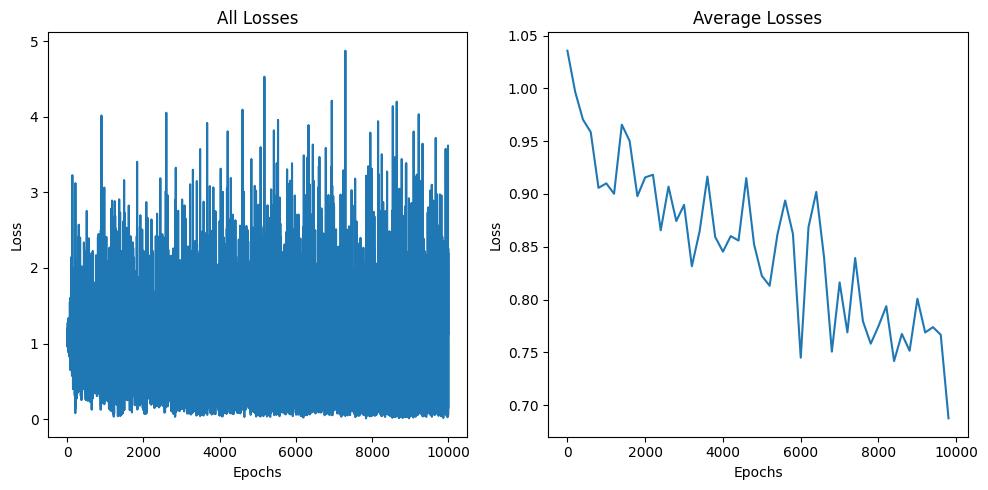

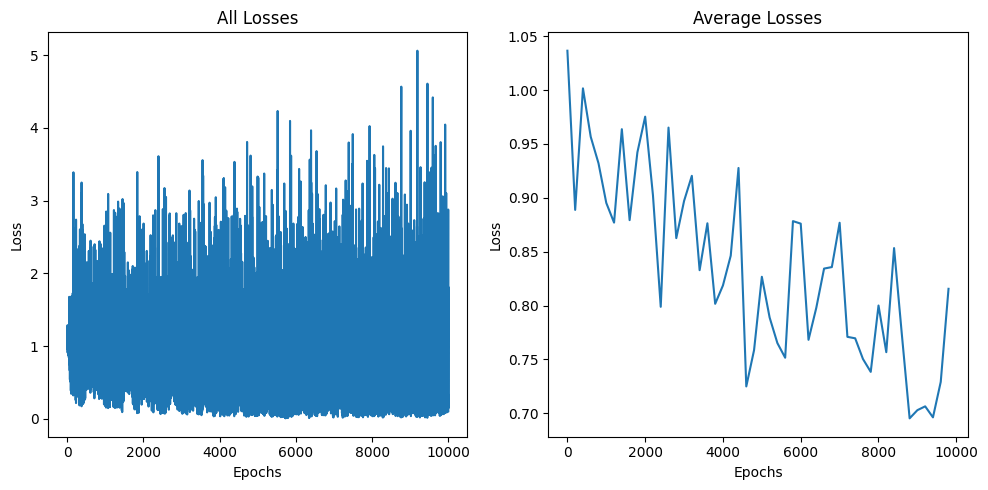

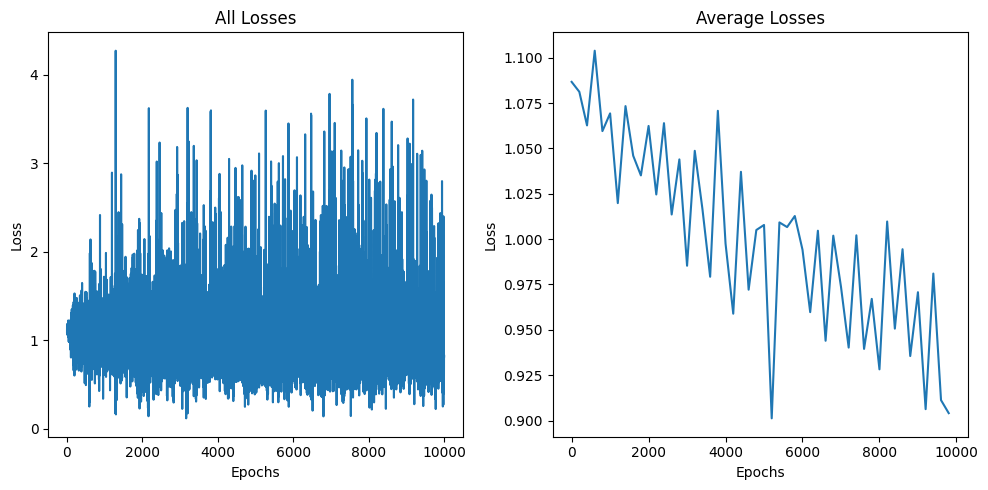

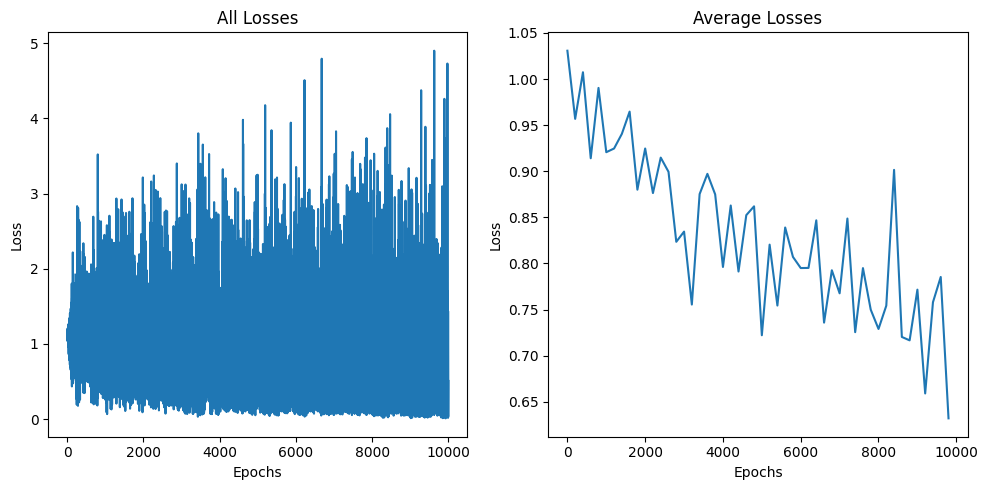

In [45]:
plot_graphs(num_epochs, plot_interval, plot_all_losses1, plot_avg_losses1)
plot_graphs(num_epochs, plot_interval, plot_all_losses2, plot_avg_losses2)
plot_graphs(num_epochs, plot_interval, plot_all_losses3, plot_avg_losses3)
plot_graphs(num_epochs, plot_interval, plot_all_losses4, plot_avg_losses4)

# 3. Testing and Evaluation

In [85]:
# Function to get model's prediction on test data
def predict(encoder, decoder, sentence, aspect, integration_type):
    with torch.no_grad():
        sent = preprocess_data([sentence])[0]
        sent_idx = [word_to_idx[word] for word in sent]
        aspect_idx = word_to_idx[aspect]
        no_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=False)
        with_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=True)
        rep_sep_idx = combine_repeat_aspect(sent_idx, aspect_idx, has_sep=True)
        rep_idx = combine_repeat_aspect(sent_idx, aspect_idx, has_sep=False)
        aspect_tensor = torch.LongTensor([[aspect_idx]])
        
        if integration_type == NO_ASPECT:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, encoder.hidden_size)
        elif integration_type == WITH_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in with_sep_idx])
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH+1, encoder.hidden_size)
        elif integration_type == ASPECT_EMBED:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, encoder.hidden_size)
        elif integration_type == NO_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in no_sep_idx])
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH, encoder.hidden_size)
        elif integration_type == ASPECT_REP_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in rep_sep_idx])
            encoder_hiddens = torch.zeros(MAX_REPSEP_LENGTH, encoder.hidden_size)
        elif integration_type == ASPECT_REP:
            input_tensor = torch.LongTensor([[idx] for idx in rep_idx])
            encoder_hiddens = torch.zeros(MAX_REP_LENGTH, encoder.hidden_size)
        
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()
        encoder_cell = encoder.init_hidden()
        for ei in range(input_length):
            _, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], encoder_hidden, encoder_cell, aspect_tensor)
            encoder_hiddens[ei] = encoder_hidden[0, 0]
            
        y_output = decoder(encoder_hidden, encoder_hiddens)
        _, topi = y_output.topk(1)
        polarity = idx_to_polarity[topi[0].item()]
        return polarity

# Function to calculate model accuracy on test data
def evaluate(encoder, decoder, test_data, integration_type):
    correct = 0
    for i in range(len(test_data)):
        sentence = test_data[i]
        aspect = test_a[i]
        polarity = test_y[i]
        pred_polarity = predict(encoder, decoder, sentence, aspect, integration_type)
        if pred_polarity == polarity:
            correct += 1
    accuracy = correct / len(test_data)
    return accuracy

## Repeat Aspect no Separator

In [86]:
# Get the accuracy of the model on test data
integration_type = ASPECT_REP
accuracy0 = evaluate(encoder5, decoder5, test_x, integration_type)
print(f'Accuracy: {accuracy0:.4f}')

Accuracy: 0.6382


## Repeat Aspect with Separator

In [73]:
# Get the accuracy of the model on test data
integration_type = ASPECT_REP_SEP
accuracy0 = evaluate(encoder0, decoder0, test_x, integration_type)
print(f'Accuracy: {accuracy0:.4f}')

Accuracy: 0.6171


## Aspect Embedding

In [47]:
# Get the accuracy of the model on test data
integration_type = ASPECT_EMBED
accuracy1 = evaluate(encoder1, decoder1, test_x, integration_type)
print(f"Accuracy: {accuracy1:.4f}")

Accuracy: 0.6238


## With Separator

In [48]:
# Get the accuracy of the model on test data
integration_type = WITH_SEP
accuracy2 = evaluate(encoder2, decoder2, test_x, integration_type)
print(f"Accuracy: {accuracy2:.4f}")

Accuracy: 0.6393


## No Aspect

In [49]:
# Get the accuracy of the model on test data
integration_type = NO_ASPECT
accuracy3 = evaluate(encoder3, decoder3, test_x, integration_type)
print(f"Accuracy: {accuracy3:.4f}")

Accuracy: 0.4617


## No Separator

In [50]:
# Get the accuracy of the model on test data
integration_type = NO_SEP
accuracy4 = evaluate(encoder4, decoder4, test_x, integration_type)
print(f"Accuracy: {accuracy4:.4f}")

Accuracy: 0.6060
